In [1]:
from google.colab import drive
drive.mount('/content/drive')

#data_integration_file_path="/content/drive/MyDrive/DS_project/Data/5_Inter-cohort_preprocessing/5.5Multi-omics_integration/"
data_integration_file_path="/content/drive/MyDrive/DS_project/Data/5_Inter-cohort_preprocessing/5.5Multi-omics_integration/Z_output/"

#data_cluster_file_path= "/content/drive/MyDrive/DS_project/Data/6_Unsupervised_clustering/kmeans_n_init_10/"
data_cluster_file_path= "/content/drive/MyDrive/DS_project/Data/6_Unsupervised_clustering/kmeans_30mixed/"

data_clinical_file_path= "/content/drive/MyDrive/DS_project/Data/9_Biological_Interpretation/9.1_Cluster_Annotation/"

data_annotation_file_path="/content/drive/MyDrive/DS_project/Data/9_Biological_Interpretation/9.1_Cluster_Annotation/"

Mounted at /content/drive


In [2]:
!pip install lifelines
import pickle
import os
import joblib
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=0a5431c0f2c5da9e744a5f6abb428aaf5440c1cc99eb9cbff1c97ad5b9c4cc87
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


#### merge latent files

In [3]:
'''
with open(data_integration_file_path + 'train_latent_output.pickle', 'rb') as f:
  train_latent_output = pickle.load(f)

with open(data_integration_file_path + 'val_latent_output.pickle', 'rb') as f:
  val_latent_output = pickle.load(f)

with open(data_integration_file_path + 'external_test_latent_output.pickle', 'rb') as f:
  external_test_latent_output = pickle.load(f)

with open(data_integration_file_path + 'internal_test_latent_output.pickle', 'rb') as f:
  internal_test_latent_output = pickle.load(f)
'''
with open(data_integration_file_path + '30mixed_train_latent_output.pickle', 'rb') as f:
  train_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_val_latent_output.pickle', 'rb') as f:
  val_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_internal_test_latent_output.pickle', 'rb') as f:
  internal_test_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_external_test_latent_output.pickle', 'rb') as f:
  external_test_latent_output = pickle.load(f)

datasets = {
  "train": train_latent_output,
  "val": val_latent_output,
  "internal_test": internal_test_latent_output,
  "external_test": external_test_latent_output
}


GBM = {
  "train": pd.DataFrame(),
  "val": pd.DataFrame(),
  "internal_test": pd.DataFrame(),
  "external_test": pd.DataFrame()
}

LGG = {
  "train": pd.DataFrame(),
  "val": pd.DataFrame(),
  "internal_test": pd.DataFrame(),
  "external_test": pd.DataFrame()
}

for set_name, data_list in datasets.items():
  for sample in data_list:
    sample_id = sample['sample_id']
    label = sample['label']  # 'GBM' or 'LGG'
    vector = sample['latent_vector']

    df_row = pd.DataFrame([vector], columns=[f"Factor{i+1}" for i in range(len(vector))], index=[sample_id])

    if label == 'GBM':
      GBM[set_name] = pd.concat([GBM[set_name], df_row])
    elif label == 'LGG':
      LGG[set_name] = pd.concat([LGG[set_name], df_row])
    else:
      print(f"unknown: {label}, {sample_id}")

merged_datasets = {
  "train": pd.DataFrame(),
  "val": pd.DataFrame(),
  "internal_test": pd.DataFrame(),
  "external_test": pd.DataFrame()
}


for set_name in merged_datasets.keys():
  gbm_df = GBM[set_name].copy()
  lgg_df = LGG[set_name].copy()

  if not gbm_df.empty:
    gbm_df['label'] = 'GBM'
    gbm_df['set'] = set_name
  if not lgg_df.empty:
    lgg_df['label'] = 'LGG'
    lgg_df['set'] = set_name

  merged_datasets[set_name] = pd.concat([gbm_df, lgg_df])

'''
for name, df in merged_datasets.items():
  print(f"\n=== {name.upper()} ===")
  print(df.head(2))
  print("Shape:", df.shape)
  print("Label counts:\n", df['label'].value_counts())
'''

'\nfor name, df in merged_datasets.items():\n  print(f"\n=== {name.upper()} ===")\n  print(df.head(2))\n  print("Shape:", df.shape)\n  print("Label counts:\n", df[\'label\'].value_counts())\n'

#### merge clinical data

In [4]:
clinical_GBM = pd.read_csv(data_annotation_file_path + 'clinical_data_GBM_withIDH_dataset.tsv', sep='\t')

clinical_LGG = pd.read_csv(data_annotation_file_path + 'clinical_data_LGG_withIDH_dataset.tsv', sep='\t')

clinical_GBM["disease_type"] = "GBM"
clinical_GBM["neoplasm_histologic_grade"] = "G4"
clinical_LGG["disease_type"] = "LGG"

clinical_combined = pd.concat(
    [clinical_GBM, clinical_LGG],
    axis=0,
    join='outer',
    ignore_index=True
)

## get updated dataset information
clinical_combined = clinical_combined.drop(columns=['data_set_information'])
dataset_map = {}
for set_name, df in merged_datasets.items():
  for sample_id in df.index:
      dataset_map[sample_id] = set_name.replace('_', ' ').title()
clinical_combined['data_set_information'] = clinical_combined['sample'].map(dataset_map)
clinical_combined.dropna(subset=['data_set_information'], inplace=True)


In [5]:
clinical_combined.head()
#clinical_combined["data_set_information"].value_counts()

,bcr_patient_barcode,gender,age_at_initial_pathologic_diagnosis,days_to_death,days_to_last_followup,histological_type,prior_glioma,IDH1_status,IDH1_mutation,IDH2_status,IDH2_mutation,sample,disease_type,neoplasm_histologic_grade,tumor_location,supratentorial_localization,laterality,first_presenting_symptom,data_set_information
0,TCGA-02-0001,FEMALE,44.0,358.0,279.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0001-01C,GBM,G4,NaN,NaN,NaN,NaN,Train
1,TCGA-02-0003,MALE,50.0,144.0,144.0,Untreated primary (de novo) GBM,NO,Wildtype,NaN,Wildtype,NaN,TCGA-02-0003-01A,GBM,G4,NaN,NaN,NaN,NaN,Train
3,TCGA-02-0006,FEMALE,56.0,558.0,558.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0006-01B,GBM,G4,NaN,NaN,NaN,NaN,Val
4,TCGA-02-0007,FEMALE,40.0,705.0,705.0,Treated primary GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0007-01A,GBM,G4,NaN,NaN,NaN,NaN,Train
5,TCGA-02-0009,FEMALE,61.0,322.0,322.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,NaN,TCGA-02-0009-01A,GBM,G4,NaN,NaN,NaN,NaN,Internal Test


### read cluster results

In [6]:
K = range(2,5)

label_dict = {}

dataset =['train','val','internal_test','external_test']

for k in K:
  k_dir = os.path.join(data_cluster_file_path, f"k_{k}")
  label_dict[k] = {}
  for d in dataset:
    # read cluster label
    #label_path = os.path.join(k_dir, f"{d}_cluster_labels_fulltrain.csv")
    label_path = os.path.join(k_dir, f"{d}_cluster_labels_consensus_complete.csv")
    label_df = pd.read_csv(label_path, index_col=0)
    print(label_df.head())
    label_dict[k][d] = label_df

                  cluster label
sample                         
TCGA-02-0001-01C        1   GBM
TCGA-02-0003-01A        1   GBM
TCGA-02-0007-01A        1   GBM
TCGA-02-0011-01B        1   GBM
TCGA-02-0016-01A        1   GBM
                  cluster label
sample                         
TCGA-02-0006-01B        1   GBM
TCGA-02-0010-01A        0   GBM
TCGA-02-0047-01A        1   GBM
TCGA-02-0068-01A        0   GBM
TCGA-02-0071-01A        1   GBM
                  cluster label
sample                         
TCGA-02-0009-01A        1   GBM
TCGA-02-0014-01A        0   GBM
TCGA-02-0026-01B        1   GBM
TCGA-02-0033-01A        1   GBM
TCGA-02-0043-01A        1   GBM
                  cluster label
sample                         
TCGA-12-0615-01A        1   GBM
TCGA-12-0616-01A        1   GBM
TCGA-12-0618-01A        1   GBM
TCGA-12-0619-01A        1   GBM
TCGA-12-0656-01A        1   GBM
                  cluster label
sample                         
TCGA-02-0001-01C        2   GBM
TCGA-02-

## prepare survival data

In [7]:
def prepare_survival_data_all(clinical_df, label_dict_k):
    survival_df_list = []

    for subset, cluster_df in label_dict_k.items():
        cluster_df = cluster_df.copy()

        cluster_df = cluster_df.reset_index()
        if "sample" not in cluster_df.columns:
            cluster_df = cluster_df.rename(columns={cluster_df.columns[0]: "sample"})

        cluster_df["dataset"] = subset

        # Merge with clinical
        merged = pd.merge(
            clinical_df,
            cluster_df[["sample", cluster_df.columns[1], "dataset"]],
            on="sample",
            how="inner"
        )
        merged = merged.rename(columns={cluster_df.columns[1]: "cluster"})

        # Event: 1 = death observed, 0 = censored
        merged["event"] = merged["days_to_death"].notnull().astype(int)

        # Time: use death days or last follow-up days
        merged["time"] = merged["days_to_death"].fillna(merged["days_to_last_followup"])

        # Keep only valid rows
        merged_clean = merged.dropna(subset=["time"])
        #merged_clean = merged[["sample", "dataset", "cluster", "time", "event"]].dropna(subset=["time"])

        survival_df_list.append(merged_clean)

    survival_df = pd.concat(survival_df_list, axis=0).reset_index(drop=True)
    return survival_df

K = range(2,5)

for k in K:
  k_dir = os.path.join(data_cluster_file_path, f"k_{k}")
  label_dict[k] = {}
  for d in dataset:
    # read cluster label
    label_path = os.path.join(k_dir, f"{d}_cluster_labels_consensus_complete.csv")
    label_df = pd.read_csv(label_path, index_col=0)
    label_dict[k][d] = label_df
    survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
    #print(f"k={k}, {d}: {survival_df.}")

# Kaplan-Meier survival analysis with log-rank tests

In [68]:
def new_group(row):
  idh = row['IDH1_status']
  c = row['cluster']
  return f"{idh}-cluster{c}"

def plot_km_across_datasets(survival_df,group_col,split_by_dataset=True,k_val=None,datasets=["train", "val", "internal_test", "external_test"]):
  n_cols = len(datasets)
  collect_legend = ["histological_type","tumor_location","supratentorial_localization","new_group","Group","Grade_cluster"]
  if group_col in collect_legend:
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 6), sharey=True)
  else:
    fig, axes = plt.subplots(1, n_cols, figsize=(3.5 * n_cols, 4), sharey=True)
  if group_col == "new_group":
    survival_df['Group'] = survival_df.apply(new_group, axis=1)
    group_col = "Group"

  for i, dataset in enumerate(datasets):
    ax = axes[i]
    df = survival_df[survival_df["dataset"] == dataset].copy()
    if group_col == "cluster":
      print(df["cluster"].value_counts())
    if df.empty or df[group_col].isnull().all():
      ax.set_title(f"{dataset} (No Data)")
      ax.axis('off')
      continue

    groups = df[group_col].dropna().unique()
    kmf = KaplanMeierFitter()

    for g in sorted(groups):
      if group_col == "cluster":
        l=f"cluster {g}"
      else:
        l=f"{g}"
      group = df[df[group_col] == g]
      kmf.fit(group["time"], event_observed=group["event"], label=l)
      kmf.plot_survival_function(ax=ax, ci_show=False)

    # Log-rank test
    if len(groups) == 2:
      g1, g2 = sorted(groups)
      res = logrank_test(
          df[df[group_col] == g1]["time"], df[df[group_col] == g2]["time"],
          event_observed_A=df[df[group_col] == g1]["event"],
          event_observed_B=df[df[group_col] == g2]["event"]
      )
      p_val = res.p_value
    else:
      res = multivariate_logrank_test(df["time"], df[group_col], event_observed=df["event"])
      p_val = res.p_value

    ax.set_title(f"{dataset}\np={p_val:.2e}", fontsize=10)
    ax.set_xlabel("Days")
    if i == 0:
        ax.set_ylabel("Survival Probability")
    else:
        ax.set_ylabel("")
    ax.grid(True)
    #ax.legend(fontsize=8,loc='upper right')
    ax.legend(fontsize=8,loc='lower right')

  if group_col == "cluster":
    plt.suptitle(f"Kaplan-Meier by '{group_col}' (K={k_val})", fontsize=14)
  else:
    plt.suptitle(f"Kaplan-Meier by '{group_col}'", fontsize=14)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

def plot_km(survival_df, group_col, k_val=None,
            datasets=["train", "val", "internal_test", "external_test"],
            split_by_dataset=True):

    # === Decide layout ===
    if split_by_dataset:
        n_cols = len(datasets)
        collect_legend = ["histological_type", "tumor_location", "supratentorial_localization", "new_group"]
        figsize = (5 * n_cols, 6) if group_col in collect_legend else (3.5 * n_cols, 4)
        fig, axes = plt.subplots(1, n_cols, figsize=figsize, sharey=True)
        if n_cols == 1:
            axes = [axes]
    else:
        fig, ax = plt.subplots(figsize=(5, 5))
        axes = [ax]
        datasets = ["all"]

    if group_col == "new_group":
        survival_df["Group"] = survival_df.apply(new_group, axis=1)
        group_col = "Group"

    # === Loop over datasets ===
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        if split_by_dataset:
            df = survival_df[survival_df["dataset"] == dataset].copy()
        else:
            df = survival_df.copy()

        if df.empty or df[group_col].isnull().all():
            ax.set_title(f"{dataset} (No Data)")
            ax.axis('off')
            continue

        if group_col == "cluster":
            print(f"[{dataset}] Cluster counts:\n", df["cluster"].value_counts())

        groups = df[group_col].dropna().unique()
        kmf = KaplanMeierFitter()

        for g in sorted(groups):
            label = f"cluster {g}" if group_col == "cluster" else str(g)
            subset = df[df[group_col] == g]
            kmf.fit(subset["time"], event_observed=subset["event"], label=label)
            kmf.plot_survival_function(ax=ax, ci_show=False)

        # === Log-rank test ===
        if len(groups) == 2:
            g1, g2 = sorted(groups)
            res = logrank_test(
                df[df[group_col] == g1]["time"], df[df[group_col] == g2]["time"],
                event_observed_A=df[df[group_col] == g1]["event"],
                event_observed_B=df[df[group_col] == g2]["event"]
            )
        else:
            res = multivariate_logrank_test(df["time"], df[group_col], event_observed=df["event"])
        p_val = res.p_value

        title = f"{dataset}\np = {p_val:.2e}" if split_by_dataset else f"All Data\np = {p_val:.2e}"
        ax.set_title(title, fontsize=11)
        ax.set_xlabel("Days")
        if i == 0:
            ax.set_ylabel("Survival Probability")
        else:
            ax.set_ylabel("")
        ax.grid(True)
        ax.legend(fontsize=8,loc='upper right')

    main_title = f"Kaplan-Meier by '{group_col}'" + (f" (K={k_val})" if group_col == "cluster" and k_val else "")
    plt.suptitle(main_title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## GBM vs. LGG




=== Kaplan-Meier for GBM vs LGG ===


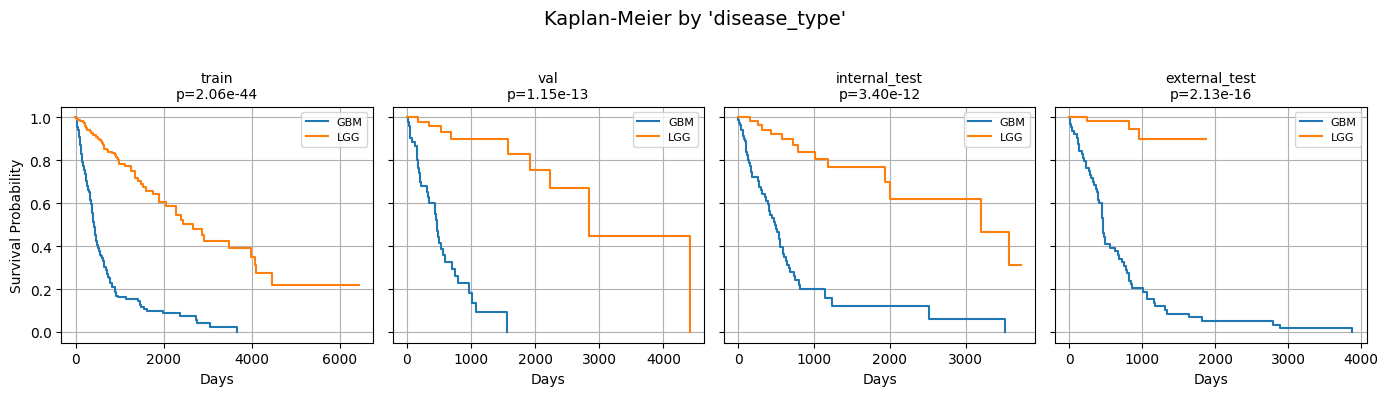

In [9]:
for k in range(2,3):
  print(f"=== Kaplan-Meier for GBM vs LGG ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="disease_type", k_val=k)

## GBM vs. LGG(G2) vs. LGG(G3)

=== Kaplan-Meier for Grade ===


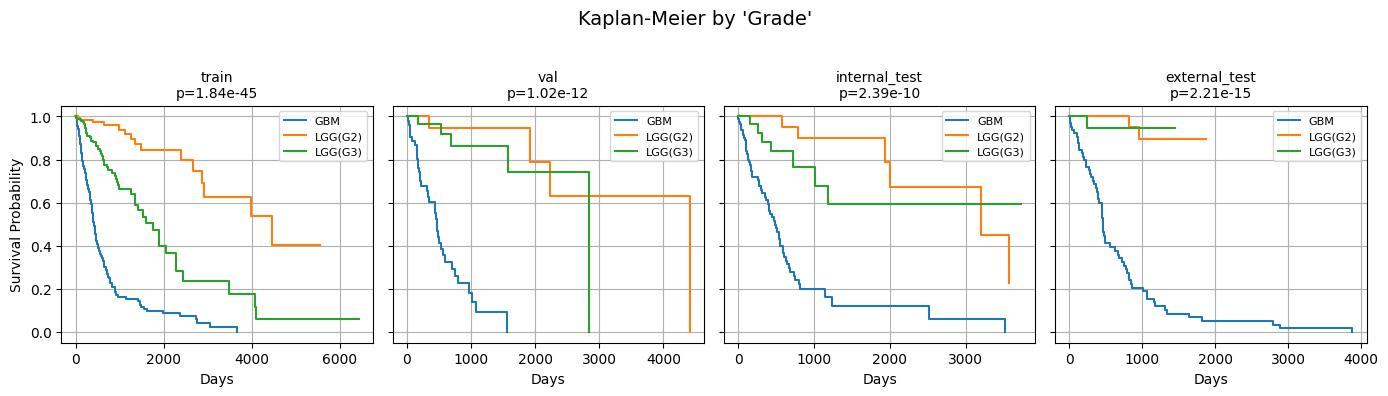

In [50]:
def tumor_grade_group(row):
    if row['neoplasm_histologic_grade'] == 'G4':
        return 'GBM'
    elif row['neoplasm_histologic_grade'] == 'G2':
        return 'LGG(G2)'
    elif row['neoplasm_histologic_grade'] == 'G3':
        return 'LGG(G3)'
    else:
        return np.nan

for k in range(2,3):
  print(f"=== Kaplan-Meier for Grade ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  survival_df['Grade'] = survival_df.apply(tumor_grade_group, axis=1)
  plot_km_across_datasets(survival_df,group_col="Grade", k_val=k)


#### Grade + cluster

=== Kaplan-Meier for Grade ===


/tmp/ipython-input-65-413795546.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df_grade['Grade_cluster'] = survival_df_grade.apply(grade_group, axis=1)


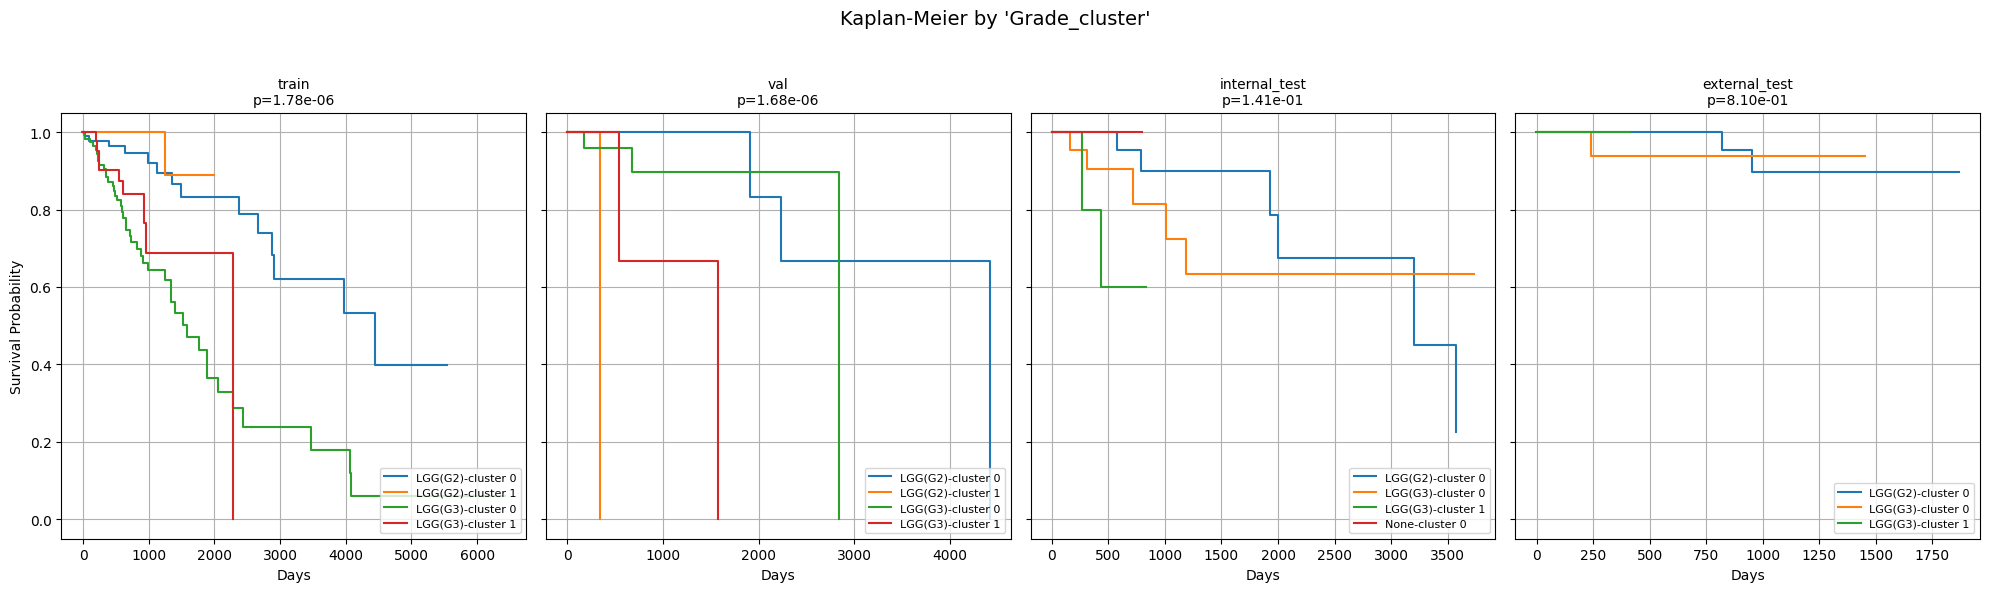

=== Kaplan-Meier for Grade ===


/tmp/ipython-input-65-413795546.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df_grade['Grade_cluster'] = survival_df_grade.apply(grade_group, axis=1)


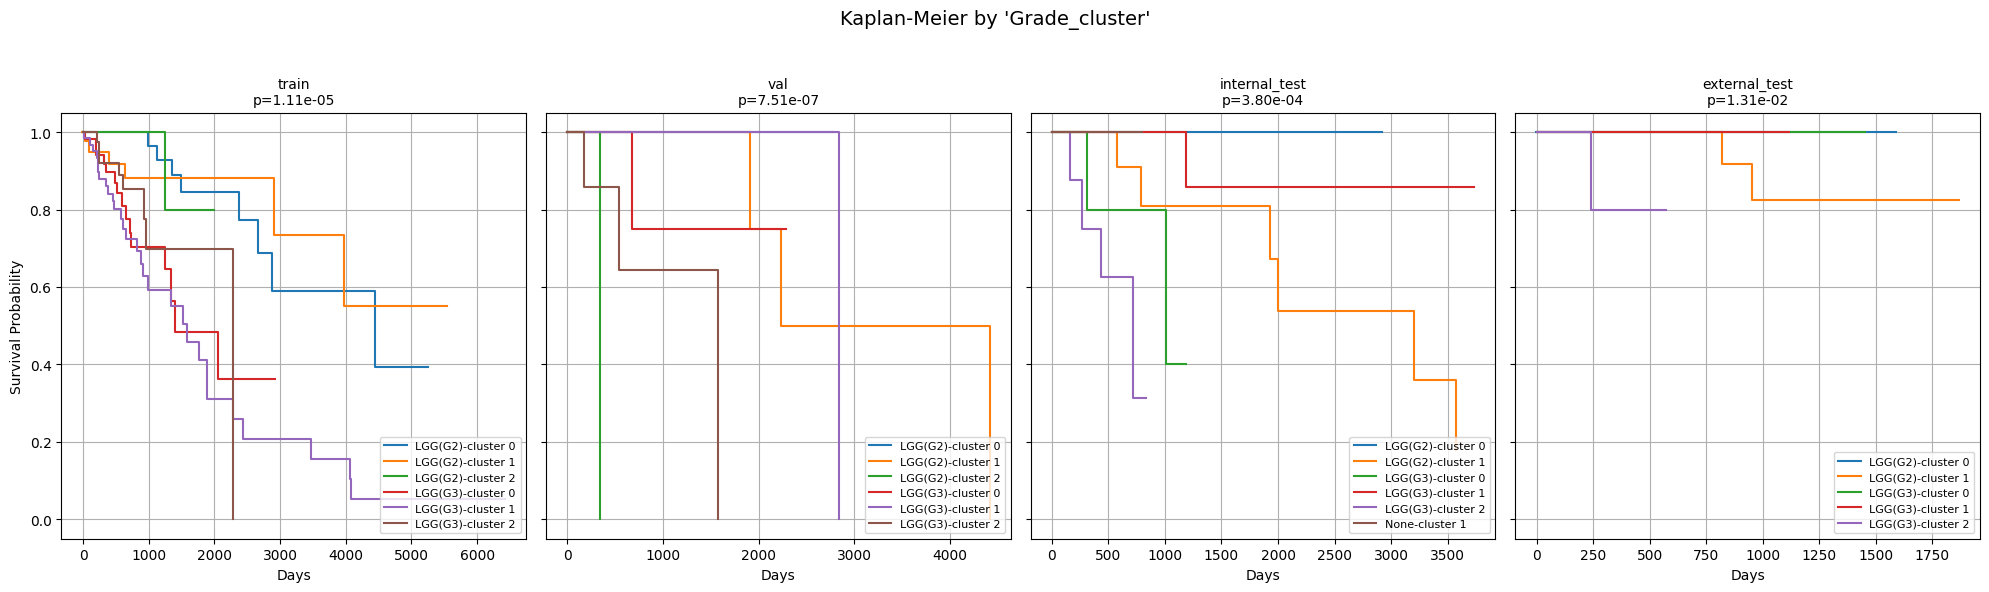

In [65]:
def grade_group(row):
    cluster = row['cluster']
    grade = None
    if row['neoplasm_histologic_grade'] == 'G4':
        grade ='GBM'
    elif row['neoplasm_histologic_grade'] == 'G2':
        grade =  'LGG(G2)'
    elif row['neoplasm_histologic_grade'] == 'G3':
        grade = 'LGG(G3)'

    label = f"{grade}-cluster {cluster}"
    return label

for k in range(2,4):
  print(f"=== Kaplan-Meier for Grade ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  survival_df_grade = survival_df[survival_df["disease_type"] == "LGG"]
  survival_df_grade['Grade_cluster'] = survival_df_grade.apply(grade_group, axis=1)
  plot_km_across_datasets(survival_df_grade,group_col="Grade_cluster", k_val=k)

## All clusters


#### all dataset

=== Kaplan-Meier for K = 2 ===
cluster
1    313
0    263
Name: count, dtype: int64
cluster
0    57
1    54
Name: count, dtype: int64
cluster
1    80
0    66
Name: count, dtype: int64
cluster
0    65
1    64
Name: count, dtype: int64


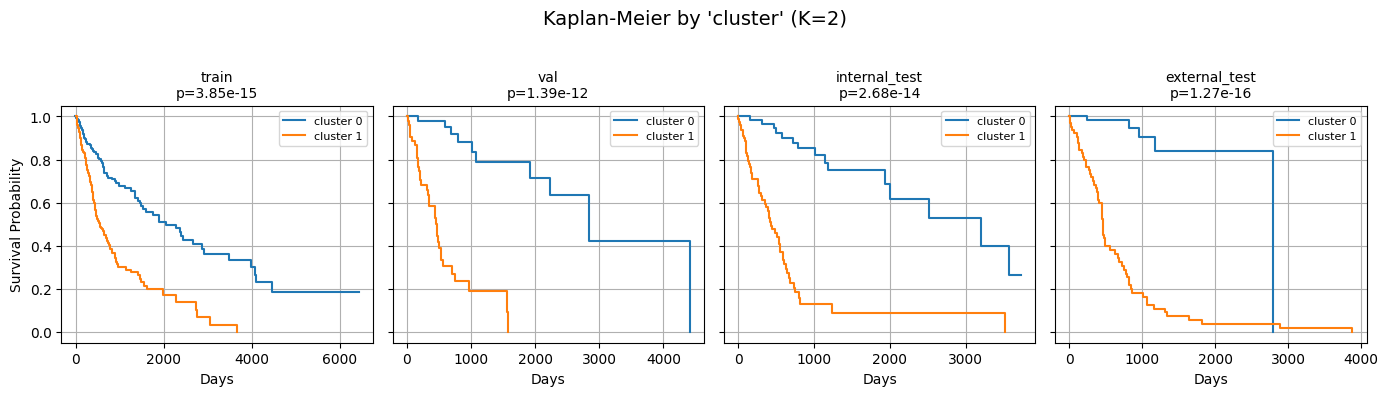

=== Kaplan-Meier for K = 3 ===
cluster
2    299
1    140
0    137
Name: count, dtype: int64
cluster
2    57
1    36
0    18
Name: count, dtype: int64
cluster
2    84
1    38
0    24
Name: count, dtype: int64
cluster
2    68
1    34
0    27
Name: count, dtype: int64


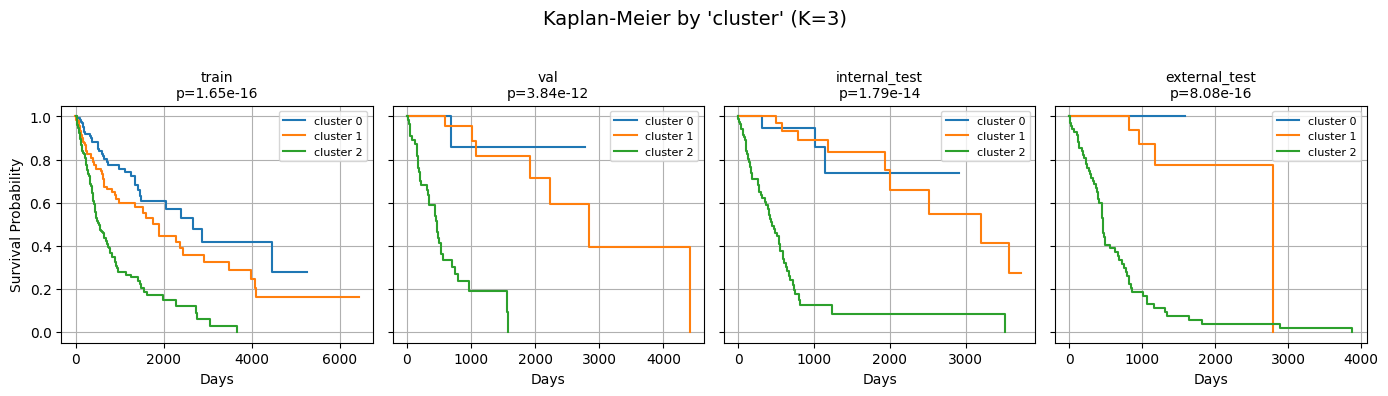

=== Kaplan-Meier for K = 4 ===
cluster
1    171
2    149
0    132
3    124
Name: count, dtype: int64
cluster
2    36
1    35
3    21
0    19
Name: count, dtype: int64
cluster
1    50
2    38
3    34
0    24
Name: count, dtype: int64
cluster
1    36
2    34
3    32
0    27
Name: count, dtype: int64


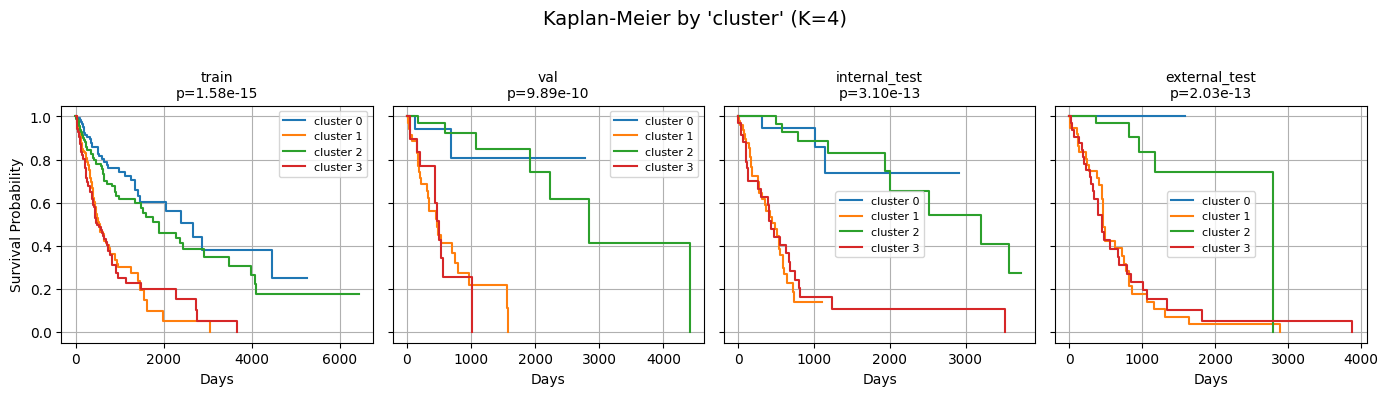

In [11]:
for k in K:
  print(f"=== Kaplan-Meier for K = {k} ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="cluster", k_val=k)

#### merge all dataset

=== Kaplan-Meier for K = 2 ===
[all] Cluster counts:
 cluster
1    511
0    451
Name: count, dtype: int64


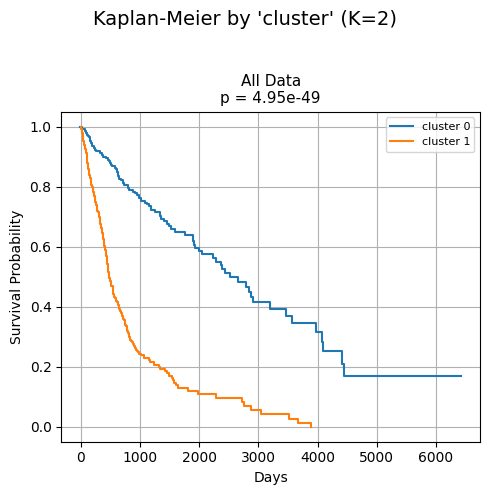

=== Kaplan-Meier for K = 3 ===
[all] Cluster counts:
 cluster
2    508
1    248
0    206
Name: count, dtype: int64


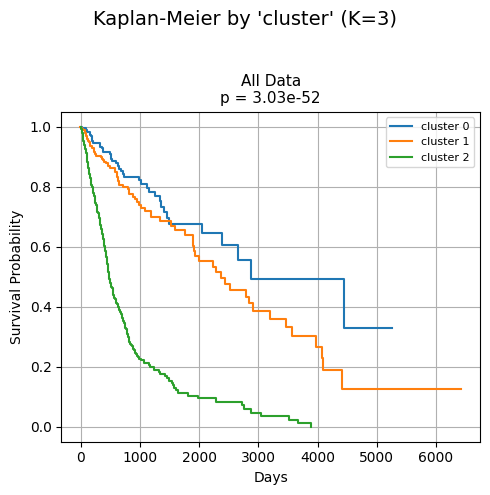

=== Kaplan-Meier for K = 4 ===
[all] Cluster counts:
 cluster
1    292
2    257
3    211
0    202
Name: count, dtype: int64


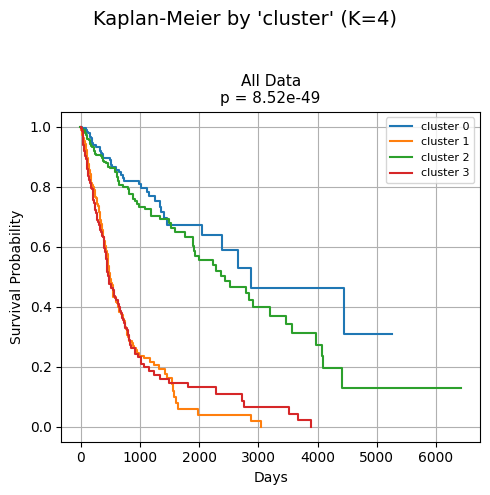

In [69]:
for k in K:
  print(f"=== Kaplan-Meier for K = {k} ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km(survival_df,group_col="cluster", k_val=k,split_by_dataset=False)

#### Pairwise

🔍 Pairwise log-rank test results for cluster:
0 vs 1 → p = 2.9657e-02
0 vs 2 → p = 1.8110e-14
1 vs 2 → p = 4.0799e-08


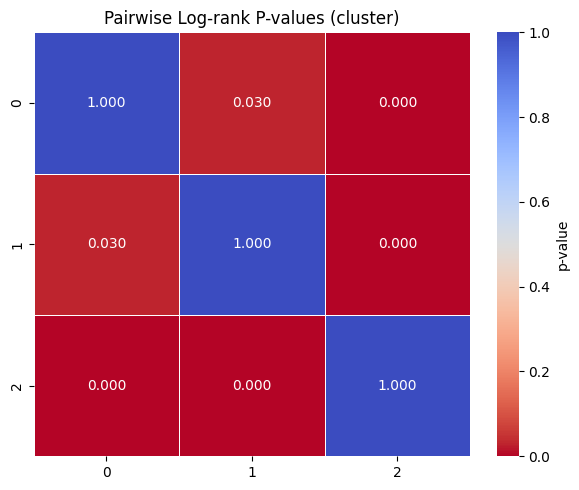

,0,1,2
0,1.000000e+00,2.965665e-02,1.810974e-14
1,2.965665e-02,1.000000e+00,4.079911e-08
2,1.810974e-14,4.079911e-08,1.000000e+00


In [66]:

from itertools import combinations


def pairwise_survdiff_like(df, time_col="time", event_col="event", group_col="cluster"):
    groups = sorted(df[group_col].dropna().unique())
    pval_matrix = pd.DataFrame(np.ones((len(groups), len(groups))),
                               index=groups, columns=groups)

    print(f"🔍 Pairwise log-rank test results for {group_col}:")
    for g1, g2 in combinations(groups, 2):
        df1 = df[df[group_col] == g1]
        df2 = df[df[group_col] == g2]

        result = logrank_test(df1[time_col], df2[time_col],
                              event_observed_A=df1[event_col],
                              event_observed_B=df2[event_col])

        p = result.p_value
        pval_matrix.loc[g1, g2] = p
        pval_matrix.loc[g2, g1] = p
        print(f"{g1} vs {g2} → p = {p:.4e}")

    # 热图可视化
    plt.figure(figsize=(6, 5))
    sns.heatmap(pval_matrix, annot=True, cmap="coolwarm_r", vmin=0, vmax=1,
                cbar_kws={'label': 'p-value'}, fmt=".3f", linewidths=0.5)
    plt.title(f"Pairwise Log-rank P-values ({group_col})")
    plt.tight_layout()
    plt.show()

    return pval_matrix

pairwise_survdiff_like(survival_df[survival_df["dataset"] == "train"],
                       time_col="time",
                       event_col="event",
                       group_col="cluster")

## GBM vs. LGG in each cluster

=== Kaplan-Meier for K = 2 ===


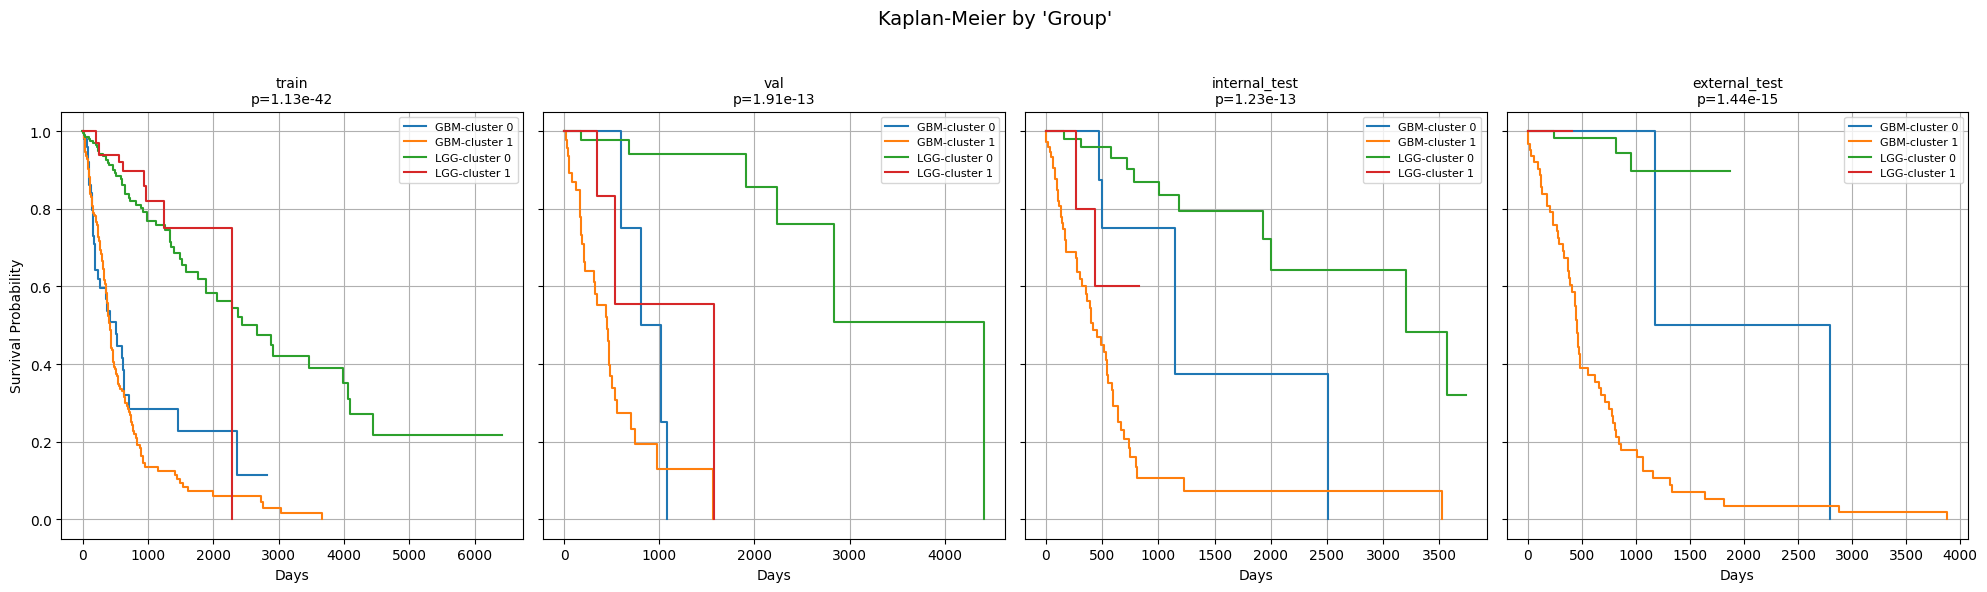

=== Kaplan-Meier for K = 3 ===


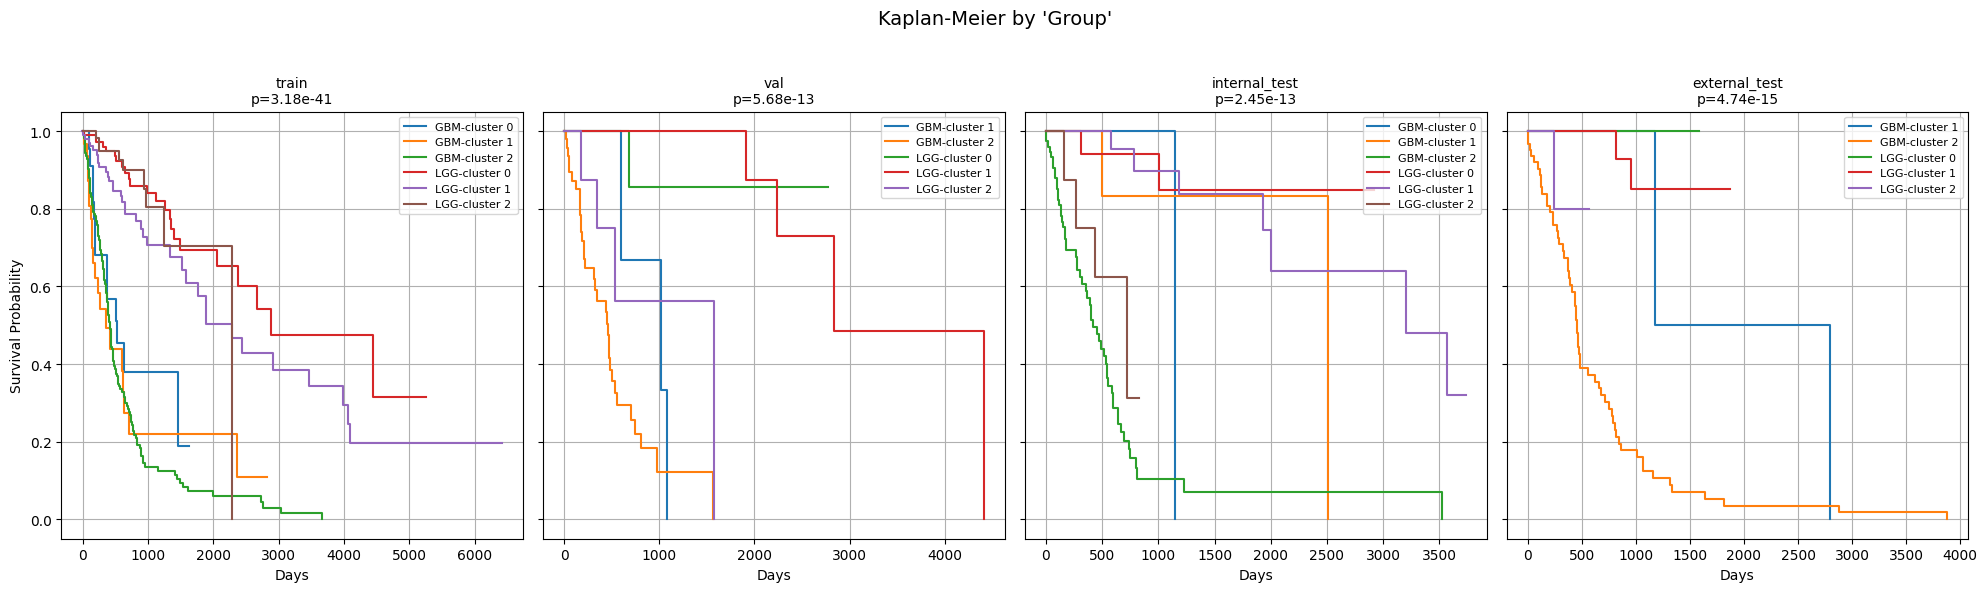

=== Kaplan-Meier for K = 4 ===


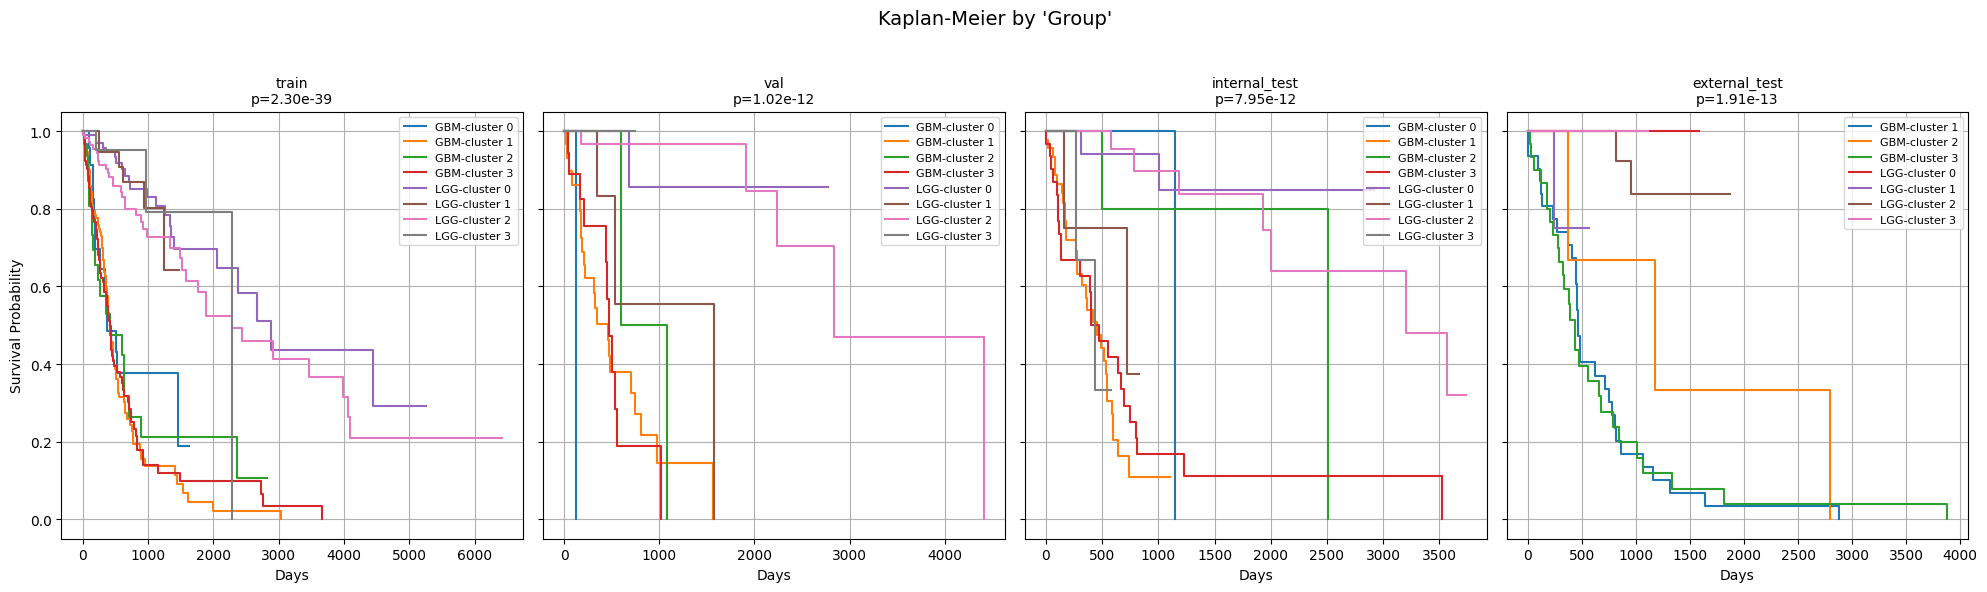

In [36]:
def disease_cluster_group(row):
  disease = row['disease_type']
  cluster = row['cluster']
  return f"{disease}-cluster {cluster}"

for k in range(2,5): ## change if need to show more
  print(f"=== Kaplan-Meier for K = {k} ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  #print(survival_df.head())
  survival_df['Group'] = survival_df.apply(disease_cluster_group, axis=1)
  plot_km_across_datasets(survival_df,group_col="Group", k_val=k)

## IDH1 mutant status

### Wildtype vs Mutant

=== Kaplan-Meier for K = 2 ===


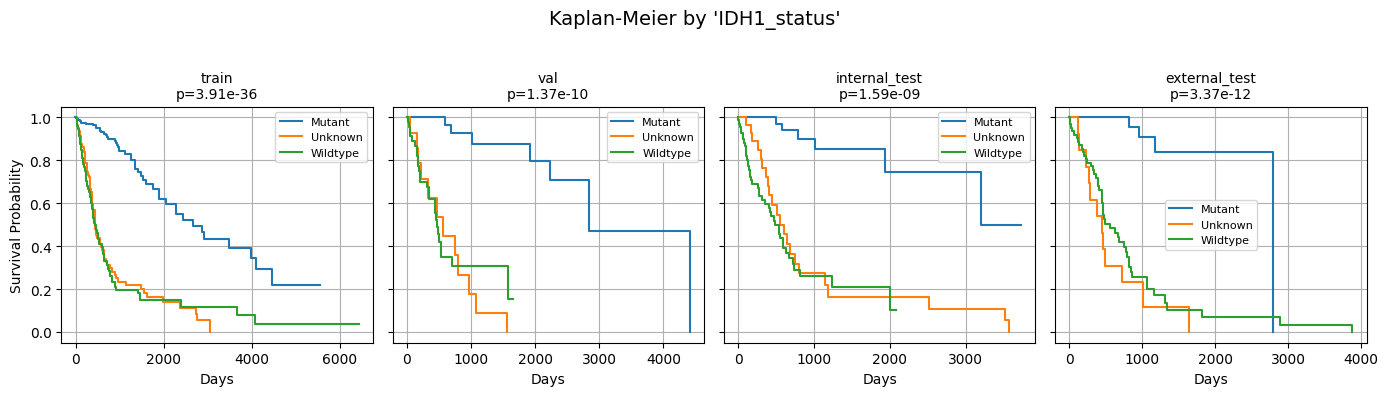

In [13]:
for k in range(2,3):
  print(f"=== Kaplan-Meier for K = {k} ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="IDH1_status", k_val=k )

### IDH1 + GBM/LGG




=== Kaplan-Meier for Grade ===


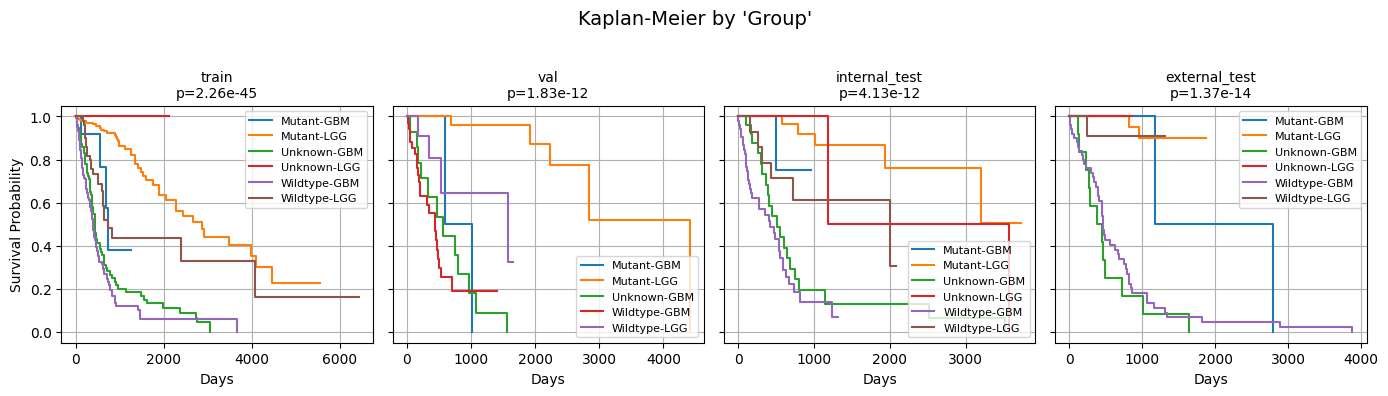

In [14]:
def new_group(row):
  idh = row['IDH1_status']
  disease = row['disease_type']
  return f"{idh}-{disease}"

for k in range(2,3):
  print(f"=== Kaplan-Meier for Grade ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  survival_df['Group'] = survival_df.apply(new_group, axis=1)
  plot_km_across_datasets(survival_df,group_col="Group", k_val=k)

### IDH1 + cluster

=== Kaplan-Meier for Group ===


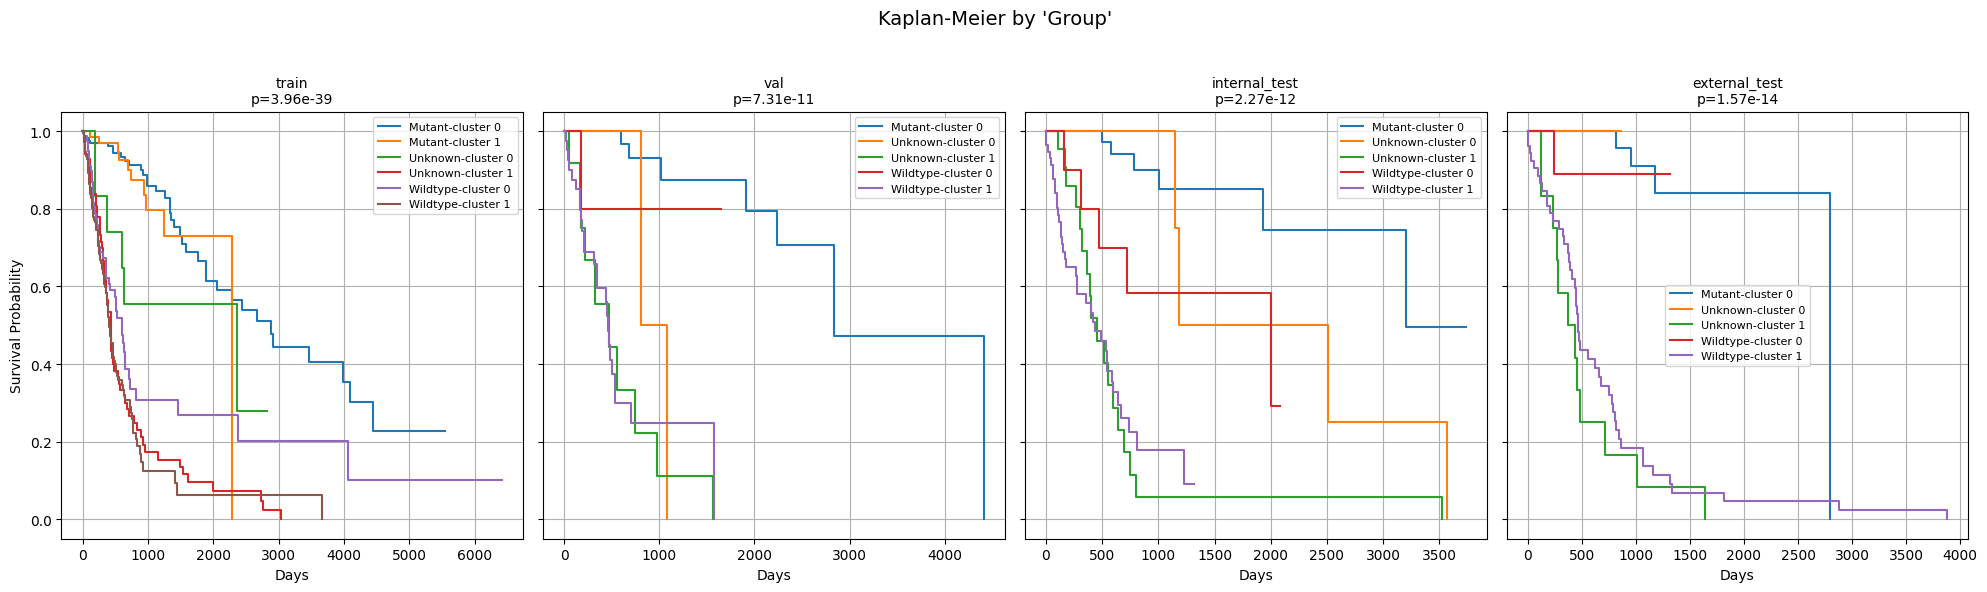

=== Kaplan-Meier for Group ===


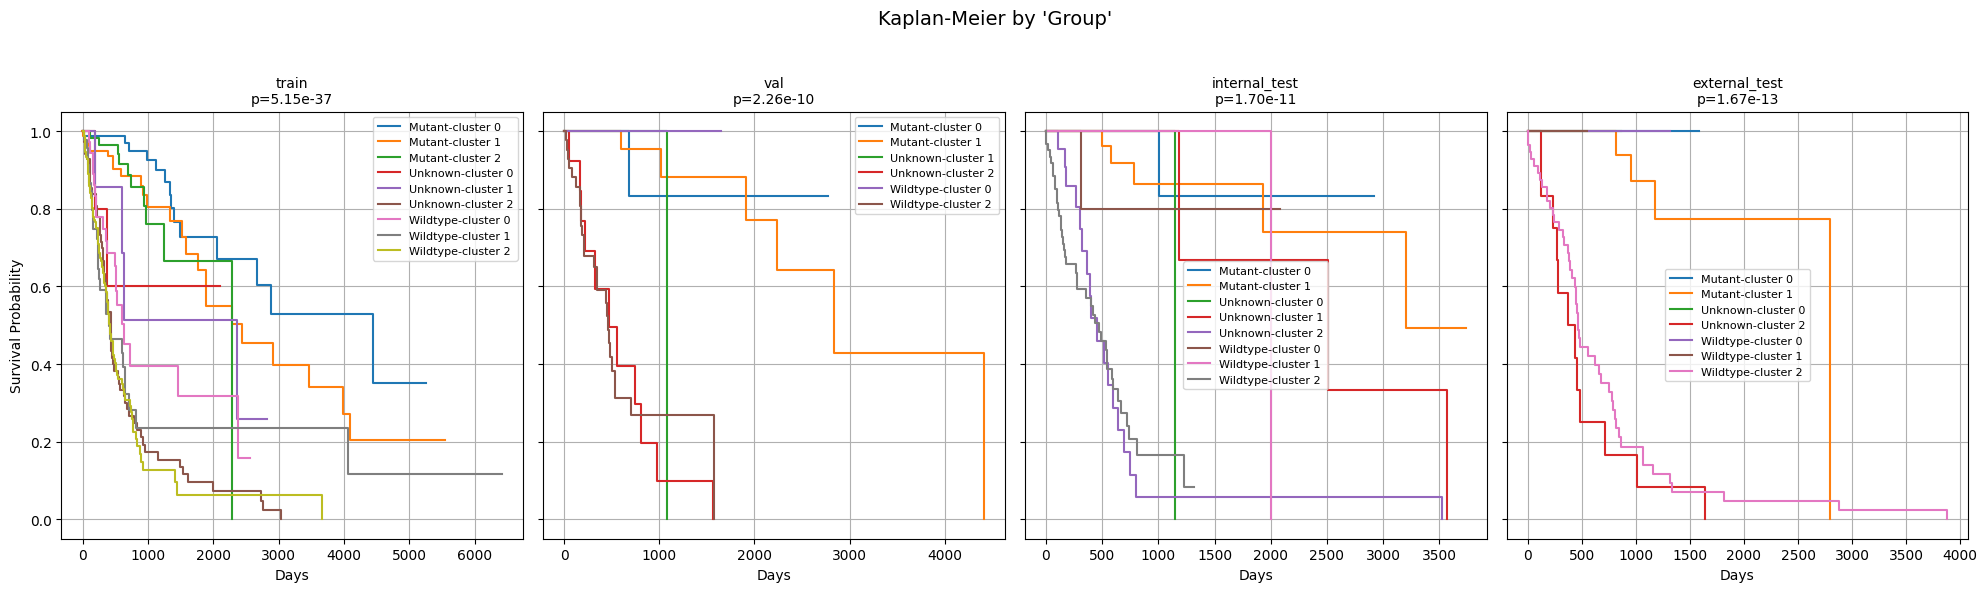

In [26]:
def new_group(row):
  idh = row['IDH1_status']
  cluster = row['cluster']
  return f"{idh}-cluster {cluster}"

for k in range(2,4):
  print(f"=== Kaplan-Meier for Group ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="new_group", k_val=k)

## Histological Type

=== Kaplan-Meier for K = 2 ===


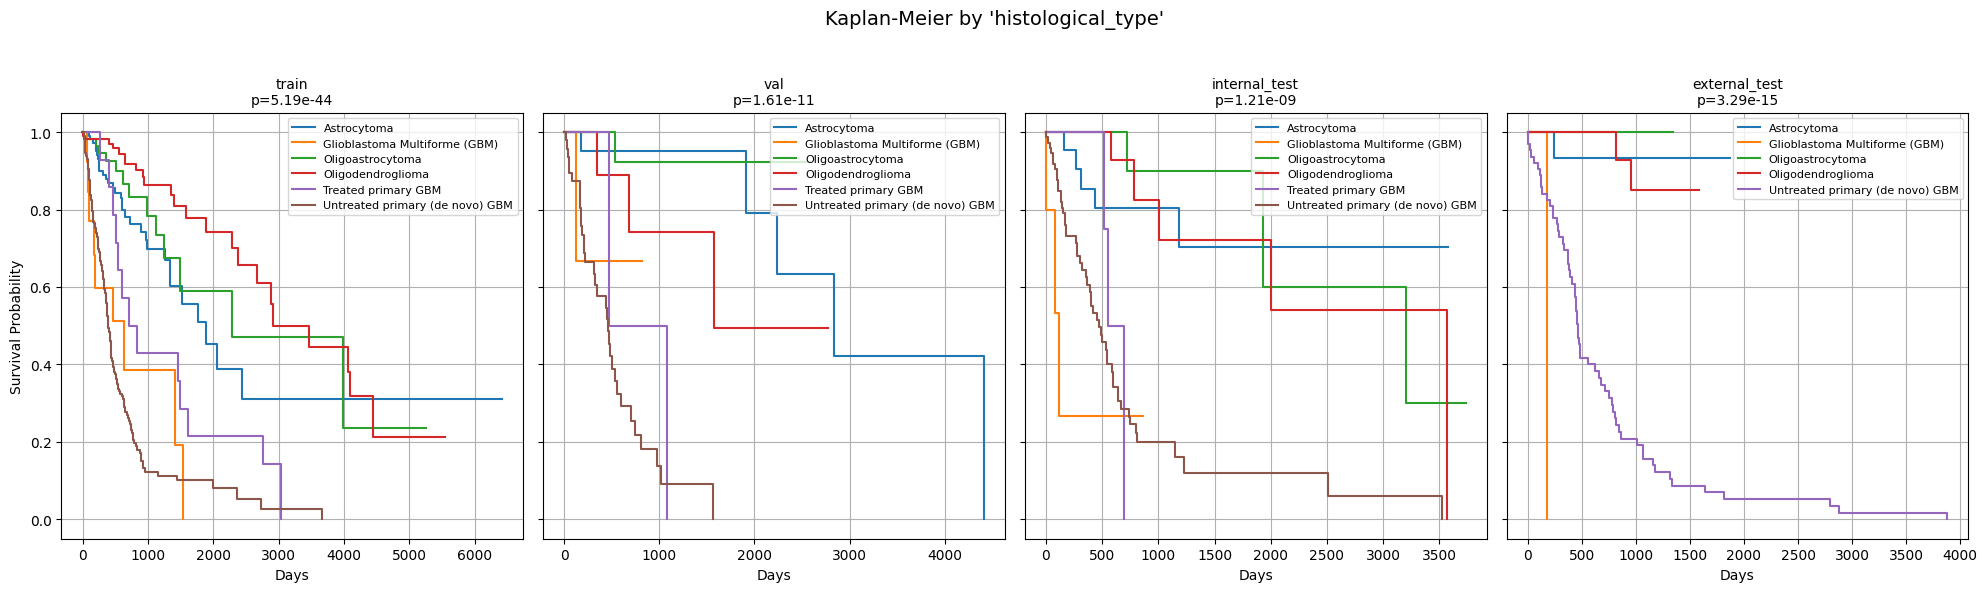

In [37]:
for k in range(2,3):
  print(f"=== Kaplan-Meier for K = {k} ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="histological_type", k_val=k)

## histological type + cluster

=== Kaplan-Meier for K = 3 ===


/tmp/ipython-input-48-4001544234.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df["Group"] = survival_df.apply(new_group, axis=1)


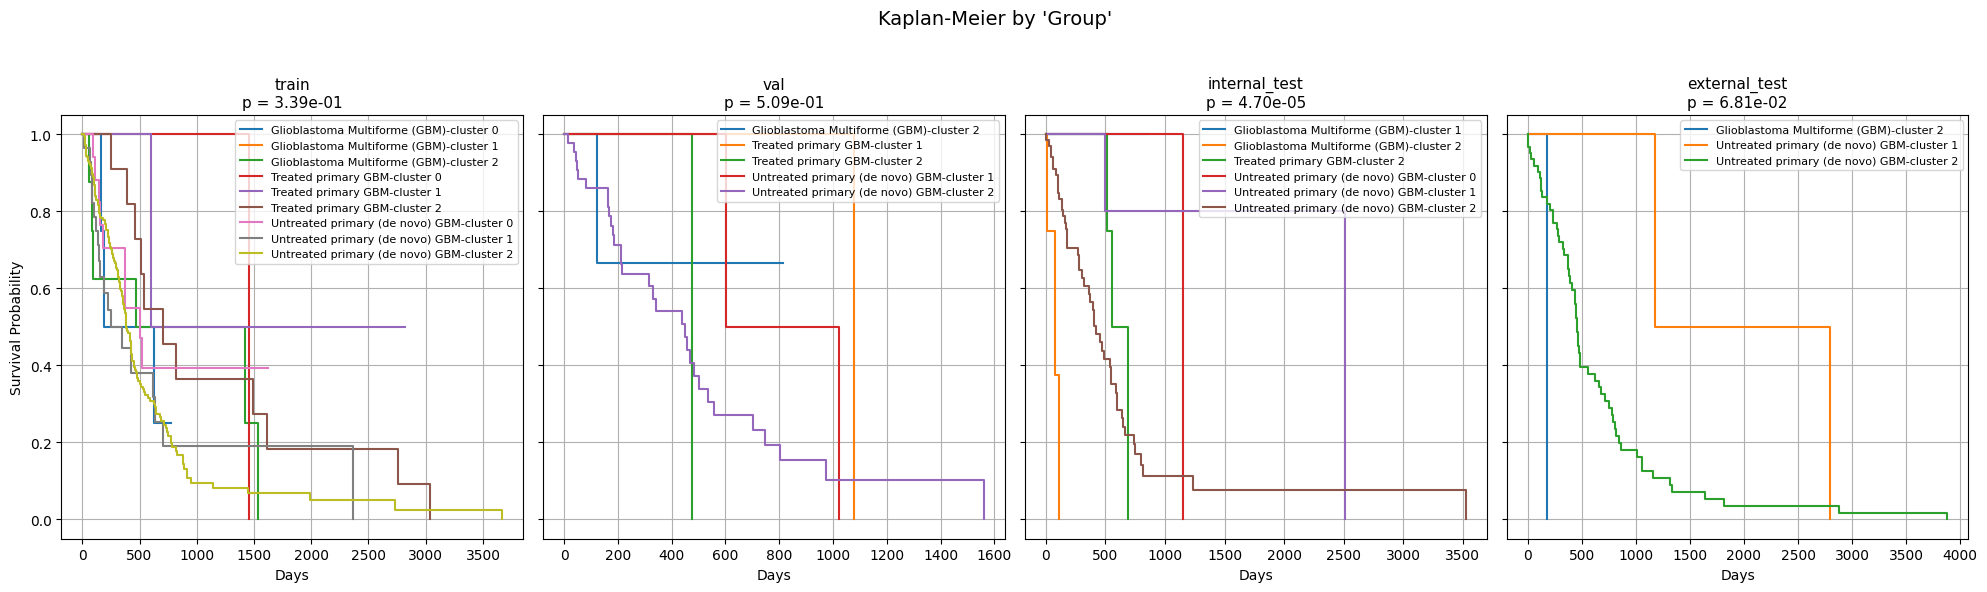

/tmp/ipython-input-48-4001544234.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_df["Group"] = survival_df.apply(new_group, axis=1)


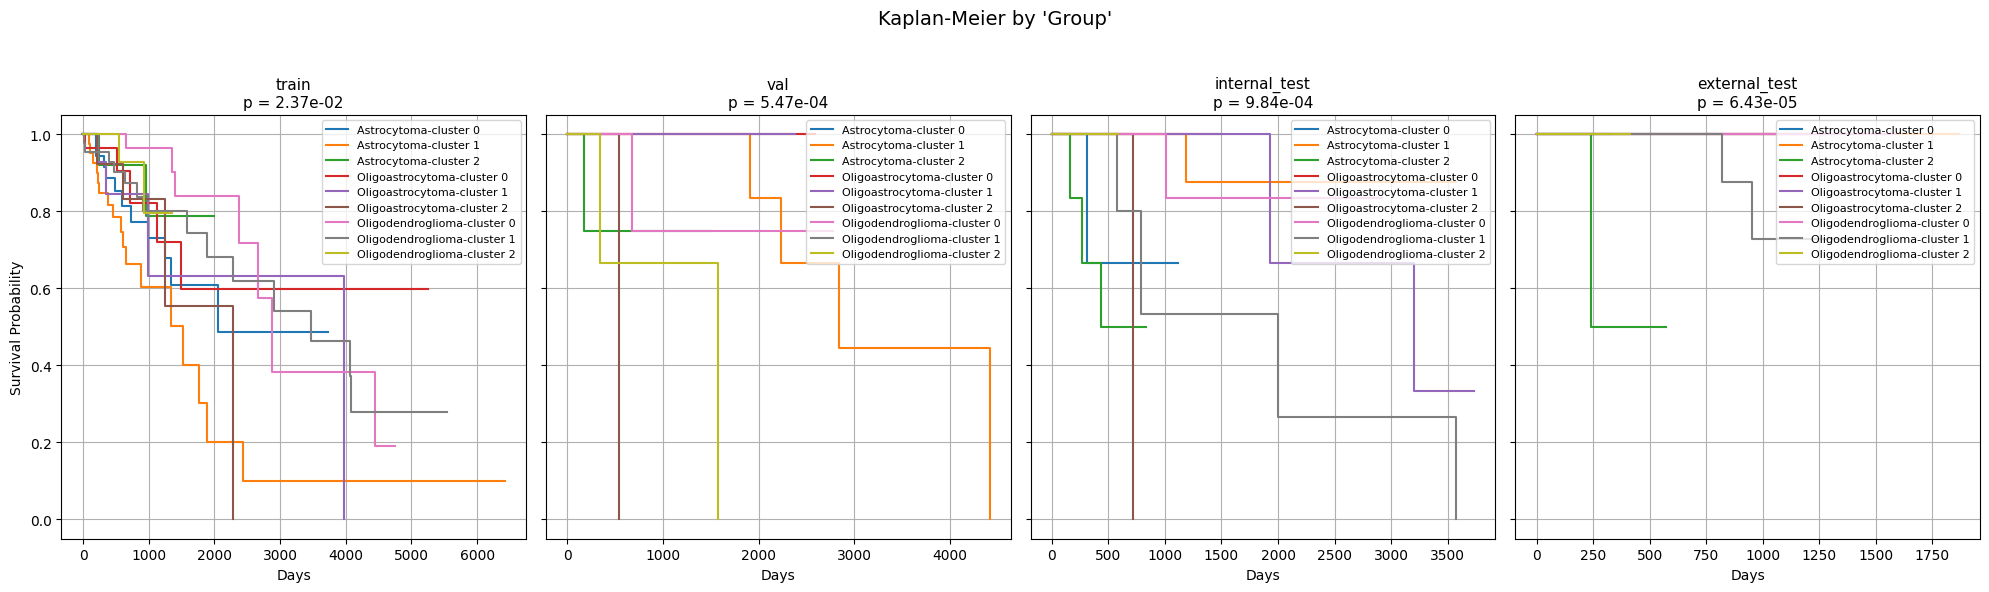

In [49]:
def new_group(row):
  disease = row['histological_type']
  cluster = row['cluster']
  return f"{disease}-cluster {cluster}"

for k in range(3,4):
  print(f"=== Kaplan-Meier for K = {k} ===")
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  survival_df['new_group'] = survival_df.apply(new_group, axis=1)
  survival_df_GBM = survival_df[survival_df["disease_type"] == "GBM"]
  survival_df_LGG = survival_df[survival_df["disease_type"] == "LGG"]
  plot_km(survival_df_GBM,group_col="new_group", k_val=k)#,split_by_dataset=False)
  plot_km(survival_df_LGG,group_col="new_group", k_val=k)

## Tumor Location (Information only for LGG)

              total_count  missing_count  missing_rate
disease_type                                          
GBM                     0            495      1.000000
LGG                   515              1      0.001938


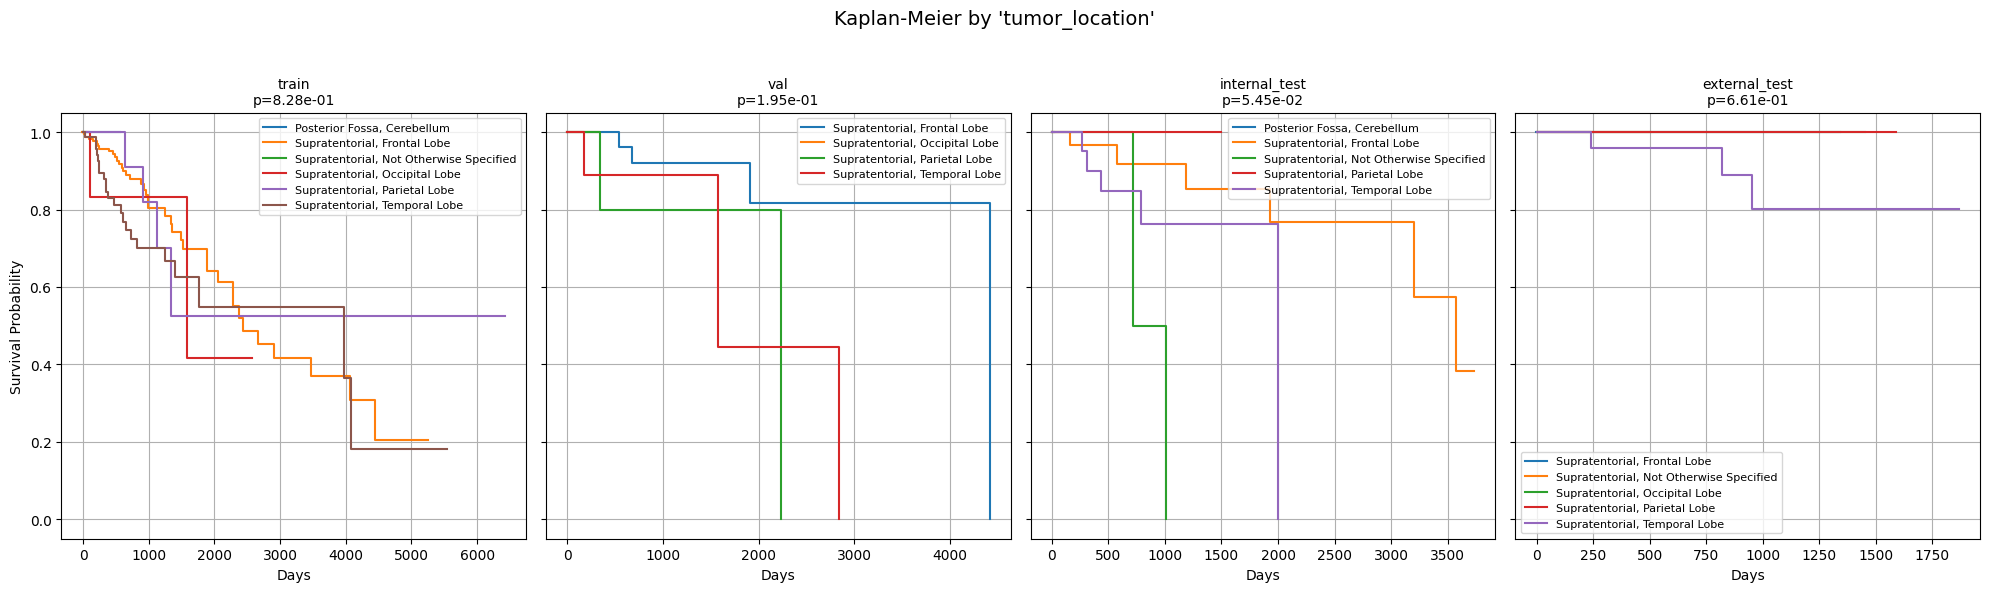

In [18]:
summary_tumor_loc = clinical_combined.groupby("disease_type")["tumor_location"].agg(
    total_count = "count",
    missing_count = lambda x: x.isna().sum()
)
summary_tumor_loc["missing_rate"] = summary_tumor_loc["missing_count"] / (summary_tumor_loc["missing_count"] + summary_tumor_loc["total_count"])
print(summary_tumor_loc)

for k in range(2,3):
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="tumor_location", k_val=k)

In [19]:
survival_df[survival_df[["disease_type", "tumor_location"]].isna().any(axis=1)]


,bcr_patient_barcode,gender,age_at_initial_pathologic_diagnosis,days_to_death,days_to_last_followup,histological_type,prior_glioma,IDH1_status,IDH1_mutation,IDH2_status,...,neoplasm_histologic_grade,tumor_location,supratentorial_localization,laterality,first_presenting_symptom,data_set_information,cluster,dataset,event,time
0,TCGA-02-0001,FEMALE,44.0,358.0,279.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,...,G4,NaN,NaN,NaN,NaN,Train,1,train,1,358.0
1,TCGA-02-0003,MALE,50.0,144.0,144.0,Untreated primary (de novo) GBM,NO,Wildtype,NaN,Wildtype,...,G4,NaN,NaN,NaN,NaN,Train,1,train,1,144.0
2,TCGA-02-0007,FEMALE,40.0,705.0,705.0,Treated primary GBM,NO,Unknown,NaN,NaN,...,G4,NaN,NaN,NaN,NaN,Train,1,train,1,705.0
3,TCGA-02-0011,FEMALE,18.0,630.0,630.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,...,G4,NaN,NaN,NaN,NaN,Train,1,train,1,630.0
4,TCGA-02-0016,MALE,50.0,NaN,1699.0,Untreated primary (de novo) GBM,NO,Unknown,NaN,NaN,...,G4,NaN,NaN,NaN,NaN,Train,1,train,0,1699.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,TCGA-41-3915,MALE,48.0,NaN,360.0,Untreated primary (de novo) GBM,NO,Wildtype,NaN,Wildtype,...,G4,NaN,NaN,NaN,NaN,External Test,1,external_test,0,360.0
893,TCGA-41-4097,FEMALE,63.0,6.0,6.0,Untreated primary (de novo) GBM,NO,Wildtype,NaN,Wildtype,...,G4,NaN,NaN,NaN,NaN,External Test,1,external_test,1,6.0
894,TCGA-41-5651,FEMALE,59.0,NaN,351.0,Untreated primary (de novo) GBM,NO,Wildtype,NaN,Wildtype,...,G4,NaN,NaN,NaN,NaN,External Test,1,external_test,0,351.0
895,TCGA-41-6646,FEMALE,73.0,NaN,236.0,Untreated primary (de novo) GBM,NO,Wildtype,NaN,Wildtype,...,G4,NaN,NaN,NaN,NaN,External Test,1,external_test,0,236.0


## Supratentorial Localization (Information only for LGG)

              total_count  missing_count  missing_rate
disease_type                                          
GBM                     0            495      1.000000
LGG                   487             29      0.056202


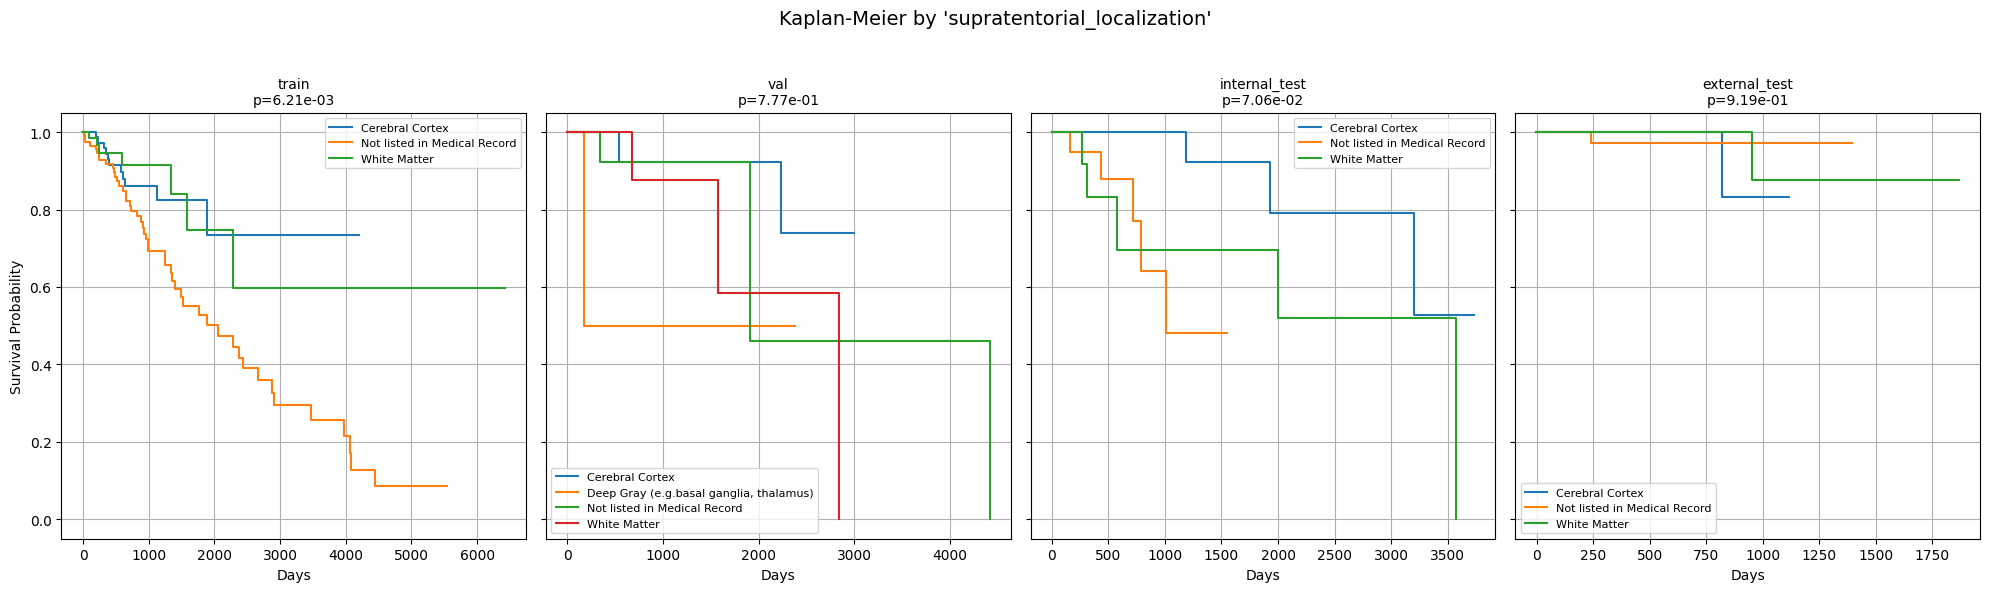

In [20]:
summary_sl = clinical_combined.groupby("disease_type")["supratentorial_localization"].agg(
    total_count = "count",
    missing_count = lambda x: x.isna().sum()
)
summary_sl["missing_rate"] = summary_sl["missing_count"] / (summary_sl["missing_count"] + summary_sl["total_count"])
print(summary_sl)

for k in range(2,3):
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="supratentorial_localization", k_val=k)

## Laterality (Information only for LGG)

              total_count  missing_count  missing_rate
disease_type                                          
GBM                     0            495       1.00000
LGG                   511              5       0.00969


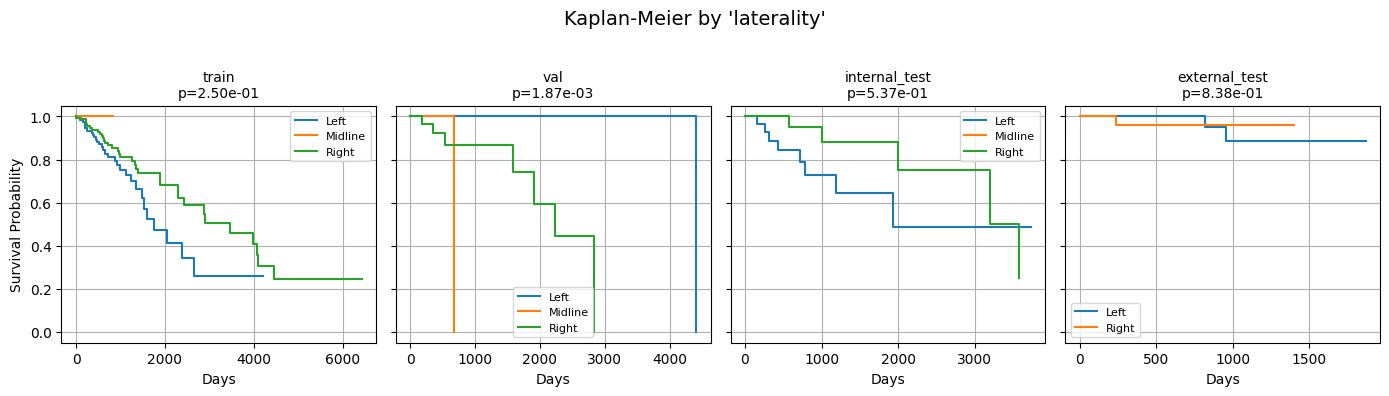

In [21]:
summary_sl = clinical_combined.groupby("disease_type")["laterality"].agg(
    total_count = "count",
    missing_count = lambda x: x.isna().sum()
)
summary_sl["missing_rate"] = summary_sl["missing_count"] / (summary_sl["missing_count"] + summary_sl["total_count"])
print(summary_sl)

for k in range(2,3):
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  plot_km_across_datasets(survival_df,group_col="laterality", k_val=k)

# Cox proportional hazards models

## seperated on different dataset

KeyError: ['cluster']

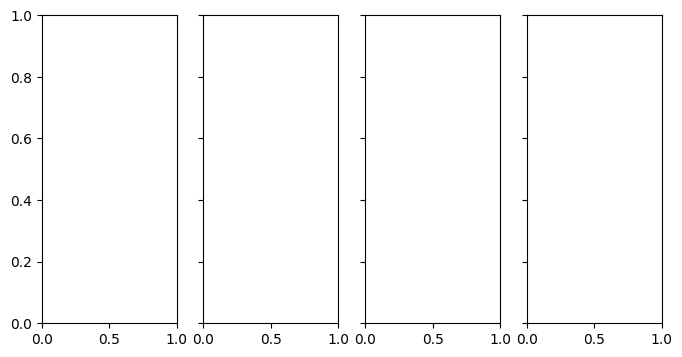

In [71]:
def run_cox_model(survival_df, covariates, k_val=None, datasets=["train", "val", "internal_test", "external_test"]):
    n_cols = len(datasets)
    fig, axes = plt.subplots(1, n_cols, figsize=(2 * n_cols, 4), sharey=True)

    if n_cols == 1:
        axes = [axes]

    model_dict = {}

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        df = survival_df[survival_df["dataset"] == dataset].copy()
        df = df.dropna(subset=["time", "event"] + covariates)

        if df.empty:
            ax.set_title(f"{dataset}\nNo Data")
            ax.axis("off")
            continue

        df_encoded = pd.get_dummies(df[covariates + ["time", "event"]], drop_first=True)

        cph = CoxPHFitter()
        cph.fit(df_encoded, duration_col="time", event_col="event")
        model_dict[dataset] = cph

        rename_dict = {
            "cluster": "Cluster",
            "age_at_initial_pathologic_diagnosis": "Age",
            "gender_MALE": "Male",
            "disease_type_GBM": "Disease Type:GBM",
            "disease_type_LGG": "Disease Type:LGG",
            "histological_type_AD": "Histological Type:AD",
            "IDH1_status_Unknown": "IDH1 Status: Unknown",
            "IDH1_status_Wildtype": "IDH1 Status: Wildtype",
            "IDH1_status_Mutant": "IDH1 Status: Mutant"
        }

        summary = cph.summary.reset_index().rename(columns={
            "index": "covariate",
            "exp(coef)": "HR",
            "exp(coef) lower 95%": "HR_lower",
            "exp(coef) upper 95%": "HR_upper"
        })
        summary = summary.sort_values("HR", ascending=False)
        summary["covariate"] = summary["covariate"].replace(rename_dict)
        ax.errorbar(
            x=summary["HR"], y=summary["covariate"],
            xerr=[summary["HR"] - summary["HR_lower"], summary["HR_upper"] - summary["HR"]],
            fmt='o', color="black", ecolor="gray", elinewidth=1, capsize=3
        )

        ax.axvline(1.0, color='red', linestyle='--', linewidth=1)
        ax.set_xscale("log")
        ax.set_title(f"{dataset}", fontsize=11)
        ax.set_xlabel("HR (log scale)", fontsize=10)
        if i == 0:
            ax.set_ylabel("Covariates")
        else:
            ax.set_ylabel("")
        ax.grid(True, linestyle="--", alpha=0.5)

    plt.suptitle(f"Cox Proportional Hazards Model (K = {k_val})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

    return model_dict


for k in range(2, 4):
    survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
    model_dict = run_cox_model(survival_df, covariates=["cluster", "age_at_initial_pathologic_diagnosis", "gender", "disease_type", "IDH1_status"], k_val=k)

    for dataset, model in model_dict.items():
        print(f"=== Cox Summary for K = {k}, Dataset = {dataset} ===")
        model.print_summary()


In [73]:
for k in range(2, 4):
  survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
  result = pd.crosstab(survival_df["cluster"], survival_df["IDH1_status"])
  print(result)

IDH1_status  Mutant  Unknown  Wildtype
cluster                               
0               320       21       110
1                69      115       327
IDH1_status  Mutant  Unknown  Wildtype
cluster                               
0               142        8        56
1               186       12        50
2                61      116       331


## all data

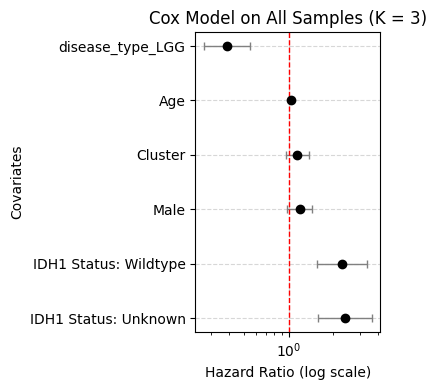

<lifelines.CoxPHFitter: fitted with 962 total observations, 520 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 962
number of events observed = 442
   partial log-likelihood = -2394.71
         time fit was run = 2025-07-14 00:12:05 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
cluster                              0.14      1.15      0.09           -0.05            0.32                0.96                1.38
age_at_initial_pathologic_diagnosis  0.04      1.04      0.00            0.03            0.04                1.03                1.05
gender_MALE                          0.17      1.18      0.10           -0.02            0.36                0.98                1.44
disease_type_LGG                    -0.95      0.38      0.18           -1.31           -0.60                0.27                0.55
IDH1_status_Unknown                  0.87      2.38      0.21            0.45            1.29                1.57                3.61
IDH1_status_Wildtype                 0.83      2.28      0.20            0.44            1.21                1.56                3.35

                                     cmp to     z      p  -log2(p)
covariate                                                         
cluster                                0.00  1.48   0.14      2.83
age_at_initial_pathologic_diagnosis    0.00  8.83 <0.005     59.77
gender_MALE                            0.00  1.72   0.09      3.54
disease_type_LGG                       0.00 -5.21 <0.005     22.36
IDH1_status_Unknown                    0.00  4.06 <0.005     14.33
IDH1_status_Wildtype                   0.00  4.22 <0.005     15.33
---
Concordance = 0.81
Partial AIC = 4801.42
log-likelihood ratio test = 508.71 on 6 df
-log2(p) of ll-ratio test = 351.96

In [42]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import pandas as pd

def run_cox_model_all_data(survival_df, covariates, k_val=None, title="Cox Model on All Samples"):
    df = survival_df.dropna(subset=["time", "event"] + covariates)
    df_encoded = pd.get_dummies(df[covariates + ["time", "event"]], drop_first=True)

    cph = CoxPHFitter()
    cph.fit(df_encoded, duration_col="time", event_col="event")

    # Format summary
    summary = cph.summary.reset_index().rename(columns={
        "index": "covariate",
        "exp(coef)": "HR",
        "exp(coef) lower 95%": "HR_lower",
        "exp(coef) upper 95%": "HR_upper"
    }).sort_values("HR", ascending=False)

    # Friendly covariate labels (adjust as needed)
    rename_dict = {
        "cluster": "Cluster",
        "age_at_initial_pathologic_diagnosis": "Age",
        "gender_MALE": "Male",
        "disease_type_GBM": "Disease Type: GBM",
        "IDH1_status_Unknown": "IDH1 Status: Unknown",
        "IDH1_status_Wildtype": "IDH1 Status: Wildtype",
        "IDH1_status_Mutant": "IDH1 Status: Mutant"
    }
    summary["covariate"] = summary["covariate"].replace(rename_dict)

    # Plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.errorbar(
        x=summary["HR"], y=summary["covariate"],
        xerr=[summary["HR"] - summary["HR_lower"], summary["HR_upper"] - summary["HR"]],
        fmt='o', color="black", ecolor="gray", elinewidth=1, capsize=3
    )
    ax.axvline(1.0, color='red', linestyle='--', linewidth=1)
    ax.set_xscale("log")
    ax.set_xlabel("Hazard Ratio (log scale)")
    ax.set_ylabel("Covariates")
    ax.set_title(title if not k_val else f"{title} (K = {k_val})")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return cph

k = 3
survival_df = prepare_survival_data_all(clinical_combined, label_dict[k])
model = run_cox_model_all_data(
    survival_df,
    covariates=["cluster", "age_at_initial_pathologic_diagnosis", "gender", "disease_type", "IDH1_status"],
    k_val=k
)

model.print_summary()
